# Compressor Simulation
---

**Importing libraries and notebook preparation**

In [1]:
import warnings
from pathlib import Path
import pandas as pd
from hvac import Quantity
from hvac.fluids import Fluid, CoolPropWarning
from hvac.vapor_compression import FixedSpeedCompressor, VariableSpeedCompressor
from hvac.charts.log_ph_diagram import StandardVaporCompressionCycle, LogPhDiagram

warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=CoolPropWarning)

Q_ = Quantity

## Polynomial Equations of Compressor Performance 

To be able to select a suitable compressor for a vapor compression machine, compressor manufacturers offer selection software programs. These programs suggest, based on the user's input, to the user one or more suitable compressor models. The input the user needs to provide, includes the type of refrigerant, the required cooling or heating capacity at design conditions, the evaporation and condensation temperature aimed at under design conditions, the target degree of refrigerant superheating at the evaporator's exit and also along the suction line, and the target degree of refrigerant subcooling at the condenser's exit.

The selection program presents tables and diagrams showing the selected compressor's performance under a variety of operating conditions, which are mainly a function of evaporation and condensation temperature, whereby the degree of refrigerant superheating and subcooling remain fixed. In addition to the tables and diagrams, most selection programs these days also offer sets of coefficients of polynomial equations that describe mathematically the compressor's performance characteristics (e.g. the refrigerant mass flow rate, the cooling capacity at the evaporator, the mechanical power delivered to the refrigerant, etc.) as a function of the evaporation and the condensing temperature, and, in case of variable speed compressors, also as a function of compressor speed. Using these polynomial equations, it is possible to simulate the performance of a given compressor under varying working conditions.

The polynomial coefficients can be exported to a spreadsheet file (or a comma-separated-values file). For each performance parameter, a different set of coefficients applies. Inside the `python-hvac` package, two classes are included to model a real compressor based on the polynomial equations offered by compressor manufacturers. One class applies to compressors with a fixed motor speed. The other class applies to compressors which are equipped with a variable speed drive.

The variables in the polynomial equations of a fixed speed compressor are the evaporation and the condensation temperature only. The polynomial equations of a variable speed compressor also contain the compressor speed as a third necessary variable.

## Compressor Models

A fixed speed compressor is modeled by the class `FixedSpeedCompressor`. A variable speed compressor is modeled by the class `VariableSpeedCompressor`.

To use these two classes, the coefficients of all performance parameters must be collected in a file that these classes recognize. For this, the coefficients must be ordered in a table-like structure saved in a file with the csv-extension (\*.csv). Examples of such files can be found in the `compressor_data` folder. The code block below opens one of these csv-file and displays the data in a table.

In [2]:
data_folder = Path("./compressor_data")
file = data_folder / "DSF175-4.csv"
table = pd.read_csv(file)
with pd.option_context('display.max_columns', None, 'display.width', 300):
    print(table)

  Unnamed: 0          C0         C1        C2        C3        C4        C5        C6        C7        C8        C9
0  Q_dot_evp   56.016601   1.803612 -0.554236  0.025915 -0.011224  0.007159  0.000209 -0.000187  0.000011 -0.000080
1      W_dot    3.143491  -0.088970  0.101522 -0.002829  0.001146  0.001204 -0.000023  0.000020  0.000013  0.000007
2          I   11.938221  -0.042187  0.023455 -0.002219 -0.001535  0.002772 -0.000025 -0.000004  0.000047  0.000009
3      m_dot  594.012615  18.390119 -4.025634  0.270240 -0.032978  0.110358  0.002695 -0.000832  0.000377 -0.001215


The coefficients of four performance quantities are contained in the file:
- cooling capacity `Q_dot_evp`
- mechanical compressor power `W_dot`
- electrical current `I` drawn by the compressor
- the refrigerant mass flow rate `m_dot`

There is also a fifth quantity that may be added, being the refrigerant discharge temperature `T_dis` at the exit of the compressor.

It is required that the same table structure and the same symbolic notations for the quantities are used. Otherwise, the file cannot be read correctly.

The polynomials that describe each of the performance quantities in the example have 10 coefficients (C0...C9), which applies to a fixed speed compressor. In the case of a variable speed compressor, the number of coefficients may be 20 (C0...C19) or 30 (C0...C29).

## Example of a Fixed Speed Compressor

A fixed speed compressor is represented by the `FixedSpeedCompressor` class. To instantiate this class, we need to:
- specify the path to the csv-file,
- the degree of refrigerant superheating for which the coefficients are valid,
- the degree of refrigerant subcooling for which the coefficients are valid, and
- the refrigerant.

In [3]:
fixed_speed_compressor = FixedSpeedCompressor(
    coeff_file=data_folder / "ZR144KCE-TFD.csv",
    dT_sh=Q_(10, 'K'),  # degree of superheat
    dT_sc=Q_(0, 'K'),   # degree of subcooling
    refrigerant=Fluid('R22')
)

> **Important Note**<br>
> It might be necessary that the default units inside the `FixedSpeedCompressor` class have to be changed to the measuring units that are used by the compressor manufacturer to quantify the performance quantities. The dictionary `units` of class `FixedSpeedCompressor` contains the following keys:
> - `'Q_dot_evp'` for the cooling capacity having default unit 'kW'
> - `'W_dot'` for the compressor power having default unit 'kW'
> - `'m_dot'` for refrigerant mass flow rate having default unit 'kg/hr'
> - `'n'` for the compressor speed having default unit 'rpm'
>
> To change units, a dictionary can be passed to the optional parameter `units` of the constructor of the `FixedSpeedCompressor` class.<br>
E.g. `{'m_dot': 'kg / s'}`.

After the compressor model has been instantiated, we set the evaporation and condensation temperature to define the operating state of the compressor inside the vapor compression machine:

In [4]:
fixed_speed_compressor.T_evp = Q_(5.0, 'degC')   # evaporation temperature
fixed_speed_compressor.T_cnd = Q_(50, 'degC')    # condensing temperature

Now we can retrieve the performance quantities of the compressor for these operating condition:

In [5]:
print(
    f"cooling capacity `Q_dot_evp` = {fixed_speed_compressor.Q_dot_evp.to('kW'):~P.2f}",
    f"compressor power `W_dot` = {fixed_speed_compressor.W_dot.to('kW'):~P.2f}",
    f"isentropic efficiency `eta_is` = {fixed_speed_compressor.eta_is.to('pct'):~P.2f}",
    f"refrigerant mass flow rate `m_dot` = {fixed_speed_compressor.m_dot.to('g/s'):~P.2f}",
    f"heat rejection rate `Q_dot_cnd` = {fixed_speed_compressor.Q_dot_cnd.to('kW'):~P.2f}",
    f"COP = {fixed_speed_compressor.COP.to('frac'):~P.2f}",
    sep='\n'
)

cooling capacity `Q_dot_evp` = 32.02 kW
compressor power `W_dot` = 9.14 kW
isentropic efficiency `eta_is` = 20.34 %
refrigerant mass flow rate `m_dot` = 58.63 g/s
heat rejection rate `Q_dot_cnd` = 41.16 kW
COP = 3.50 frac


Also, the refrigerant states at the entrance and the exit of the evaporator and condenser can be retrieved, assuming a *standard vapor compression cycle* (i.e. an idealized cycle whereby any pressure loss of the refrigerant in the evaporator, the condenser, the liquid line, the suction line, and the discharge line is not being considered).

In [6]:
with pd.option_context('display.max_columns', None, 'display.width', 300):
    print(fixed_speed_compressor.get_refrigerant_cycle())

                     T [degC]    P [bar]  rho [kg / m**3]  h [kJ / kg]  s [kJ / kg / K]
evaporator inlet     5.000000   5.841087        82.808580   263.245111         1.227325
evaporator outlet   15.000000   5.841087        23.510725   414.377603         1.770200
condenser inlet    221.772917  19.426884        42.839034   570.269823         2.066234
condenser outlet    50.000000  19.426884      1082.301952   263.245111         1.208032


The units of the state properties in the table can be modified. To do this, function `get_refrigeration_cycle` can be called with an optional dictionary containing the following keys of which the corresponding values are assigned the desired measuring unit (expressed as a string): key `'T'` for temperature, key `'P'` for pressure, key `'rho'` for mass density, key `'h'` for enthalpy, and key `'s'` for entropy.

**Log\(P\)-h Diagram**

We can draw the log\(P\)-h diagram of the vapor compression cycle using class `StandardVaporCompressionCycle`:

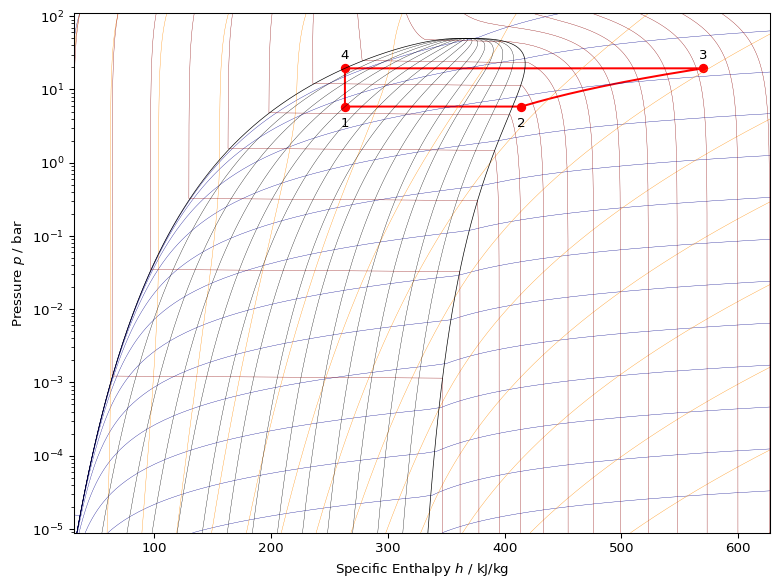

In [7]:
vc_cycle = StandardVaporCompressionCycle(
    Refrigerant=fixed_speed_compressor.refrigerant,
    evaporationTemperature=fixed_speed_compressor.T_evp,
    condensationTemperature=fixed_speed_compressor.T_cnd,
    evaporatorSuperheat=fixed_speed_compressor.dT_sh,
    subCooling=fixed_speed_compressor.dT_sc,
    suctionLineSuperheat=None,
    isentropicEfficiency=fixed_speed_compressor.eta_is
)

log_ph_diagram = LogPhDiagram(fixed_speed_compressor.refrigerant, size=(8, 6), dpi=96)
log_ph_diagram.setCycle(vc_cycle)
log_ph_diagram.show()

## Example of a Variable Speed Compressor

In [8]:
variable_speed_compressor = VariableSpeedCompressor(
    coeff_file=data_folder / "VZH088CGM.csv",
    dT_sh=Q_(10, 'K'),
    dT_sc=Q_(5, 'K'),
    refrigerant=Fluid('R32&R1234yf', mass_fractions=[Q_(0.689, 'frac'), Q_(0.311, 'frac')]),
    units={'n': 'rps'}
)

The compressor's documentation states that the frequency range of the variable speed drive is from 25 Hz to 100 Hz, which corresponds with a speed range of 1500 to 6000 revs/min. The compressor was selected with an evaporation temperature of -7 °C and a condensation temperature of 35 °C. The required heating capacity at these design conditions are met at a rotational speed of 5618 revs/min.

In [9]:
variable_speed_compressor.T_evp = Q_(-7, 'degC')
variable_speed_compressor.T_cnd = Q_(35, 'degC')
variable_speed_compressor.speed = Q_(5618, 'rpm')

In [10]:
print(
    f"Q_dot_evp = {variable_speed_compressor.Q_dot_evp.to('kW'):~P.2f}\n"
    f"W_dot = {variable_speed_compressor.W_dot.to('kW'):~P.2f}\n"
    f"eta_is = {variable_speed_compressor.eta_is.to('pct'):~P.2f}\n"
    f"m_dot = {variable_speed_compressor.m_dot.to('g/s'):~P.2f}\n"
    f"Q_dot_cnd = {variable_speed_compressor.Q_dot_cnd.to('kW'):~P.2f}\n"
    f"COP = {variable_speed_compressor.COP.to('frac'):~P.2f}"
)

Q_dot_evp = 29.99 kW
W_dot = 9.40 kW
eta_is = 63.84 %
m_dot = 136.21 g/s
Q_dot_cnd = 39.39 kW
COP = 3.19 frac


As with the `FixedSpeedCompressor` class, the magnitude of the state properties at the 4 corner points of the cycle can be requested:

In [11]:
with pd.option_context('display.max_columns', None, 'display.width', 300):
    print(variable_speed_compressor.get_refrigerant_cycle())

                    T [degC]    P [bar]  rho [kg / m**3]  h [kJ / kg]  s [kJ / kg / K]
evaporator inlet   -8.060569   5.793054        75.612504   257.826475         1.270458
evaporator outlet   3.000000   5.793054        17.786724   475.621634         2.089849
condenser inlet    91.096976  19.655507        47.072788   544.631606         2.164040
condenser outlet   30.000000  20.310615       964.684346   257.826475         1.249226


> **Note**<br>
> Although the evaporation temperature was set -7 °C, it can be noticed that according to CoolProp's calculations, the refrigerant temperature at the evaporator inlet is around -8 °C. The evaporation pressure is determined internally at the given evaporation temperature (-7 °C) and for saturated vapor ($x$ = 100 %). The enthalpy of the refrigerant at the evaporator inlet (a mixture of saturated liquid and vapor) equals the enthalpy of the subcooled liquid refrigerant at the condenser outlet, since the expansion process is considered to be isenthalpic. Based on the evaporation pressure and the enthalpy, the refrigerant temperature at the evaporator inlet is then calculated by CoolProp to be around -8 °C, instead of -7 °C. This is due to a temperature glide of the selected refrigerant.

**Log\(P\)-h Diagram**

For refrigerant mixtures, drawing a log\(P\)-h diagram throws an exception from inside CoolProp's internal code (version 6.4.1). At the time of writing this notebook, no solution was found to overcome this error.

**Minimum and Maximum Cooling Capacity at given Evaporation and Condensation Temperature**

In [12]:
variable_speed_compressor.speed = Q_(1500, 'rpm')
print(f"cooling capacity at minimum speed: {variable_speed_compressor.Q_dot_evp.to('kW'):~P.2f}")

cooling capacity at minimum speed: 7.42 kW


In [13]:
variable_speed_compressor.speed = Q_(6000, 'rpm')
print(f"cooling capacity at minimum speed: {variable_speed_compressor.Q_dot_evp.to('kW'):~P.2f}")

cooling capacity at minimum speed: 32.01 kW


**Find Compressor Speed for given Cooling Capacity at given Evaporation and Condensation Temperature**<br>
With the method `compressor_speed()` of class `VariableSpeedVariableSpeedCompressor` it is also possible to find the compressor speed at which a given cooling capacity will be met, under the currently set operating conditions (evaporation temperature, condensing temperature, degree of superheating, and degree of subcooling).

In [14]:
Q_dot_evp = Q_(10.0, 'kW')
speed = variable_speed_compressor.compressor_speed(Q_dot_evp)
print(f"cooling capacity {Q_dot_evp:~P.2f} @ {speed.to('rpm'):~P.1f}")

cooling capacity 10.00 kW @ 1957.0 rpm
